Nikita Kotelevskii

tg: @nktlvsk

# Виды неопределённости

![Sources of uncertainty](./pics/epistemic_vs_aleatoric.png)

## Алеаторная неопределённость

Алеаторная (aleatoric) неопределенность эта та часть предсказательной неопределённости, которая связана с присущим данным шумом или неотъемлемой случайностью. Характерной особенностью этой неопределённости является то, что её невозможно уменьшить добавив больше данных или усложнив модель.


Примерами неотъемлемой случайности в данных является предсказание случайного результата -- например бросок монеты.

В контексте машинного обучения алеаторную неопределенность можно далее разделить на две категории:

1. ** Гомоскедастическая неопределенность: ** Этот тип алеаторной неопределенности остается постоянным в различных точках входных данных. Обычно это происходит, когда шум в данных относительно однороден на разных входных данных. Например, при измерении роста отдельных людей погрешность измерения, вероятно, будет достаточно постоянной, что приведет к гомоскедастической неопределенности.

2. ** Гетероскедастическая неопределенность: ** Этот тип алеаторной неопределенности изменяется в зависимости от входных данных. Обычно это происходит, когда шум в данных меняется в зависимости от входных данных. Например, в задаче прогнозирования цен на жилье уровень неопределенности может быть выше для домов класса люкс (из-за меньшего количества продаж и большей изменчивости цен) по сравнению с домами средней стоимости.

Понимание и учет алеаторной неопределенности имеет важное значение во многих задачах машинного обучения для принятия надежных прогнозов и решений. Такие методы, как MaxProb и другие, используются для количественной оценки этой неопределенности и включения ее в выходные данные моделей машинного обучения.

## Эпистемическая неопределённость

Эпистемическая (epistemic) неопределенность возникает из-за недостатка знаний. В отличие от алеаторной неопределенности, которая присуща данным, эпистемическую неопределенность потенциально можно уменьшить, собрав больше данных, улучшив наши модели или собрав больше информации о рассматриваемой проблеме.

Эпистемическая неопределенность обычно возникает, когда мы имеем дело со сложными явлениями, которые наши модели не могут полностью охватить, или когда у нас есть ограниченные данные, на основе которых наши модели учатся. Неопределенность, по сути, проистекает из нашего непонимания или незнания истинного процесса, лежащего в основе получения данных.

Например, в контексте машинного обучения:

1. Если мы обучаем модель на небольшом наборе данных, модель может хорошо работать с обучающими данными, но плохо с невидимыми данными, что иллюстрирует высокую эпистемическую неопределенность. Собирая больше обучающих данных, мы потенциально можем уменьшить эту неопределенность.

2. Если мы используем упрощенную модель (например, линейную регрессию) для задачи, где истинная взаимосвязь сложна и нелинейна, предсказания модели будут иметь высокую эпистемическую неопределенность. Используя более сложную модель (например, глубокую нейронную сеть), мы потенциально можем лучше уловить сложность и уменьшить эту неопределенность.

In [1]:
# !git clone https://github.com/wjmaddox/swa_gaussian.git
# !git clone https://github.com/gpleiss/temperature_scaling.git

# Как будет устроен семинар?

- В этом ноутбуке мы посмотрим, как разные методы справятся с задачей OOD (out-of-distribution) детекции.
- У нас будут уже предобученные модели на CIFAR-100 (InD -- in-distribution).
- Будут OOD датасеты. Я выбрал два. Первый из них -- CIFAR10. Этот датасет хоть и очень похож на CIFAR100, но имеет другие, непересекающиеся классы. Тем не менее, это "близкий" OOD именно из-за сходства изображений. Второй -- SVHN (изображения цифр на домах). Это "далёкий" OOD, так как данные выглядят совсем иначе.
- Сразу же ожидаем, что для CIFAR-10 результаты OOD детекции будут выглядить хуже, чем для SVHN..
  

In [2]:
### Импортируем всё нужное
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F

from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
from copy import deepcopy
import matplotlib.pyplot as plt

from reliability_diagrams import reliability_diagram
from temperature_scaling.temperature_scaling import ModelWithTemperature
from preresnet import PreResNet20, PreResNet20Spectral
from preresnet_dropout import PreResNet20Drop

from aux import (
    plot_histogram_eq_width,
    plot_images,
    collect_labels_and_probs,
    load_emsembles,
    collect_labels_and_probs_ensemble,
    compute_scores_ensemble,
    ensemble_calibration,
    collect_labels_and_probs_mcdropout,
    compute_scores_mcdropout,
    SWAG,
    collect_labels_and_probs_swag,
    compute_scores_swag
)

In [3]:
# Зафиксируем все сиды

def seed_everything(seed: int) -> None:
    import random, os
    import numpy as np
    import torch
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
seed_everything(42)

In [4]:
# Это будет лист, в который мы запишем результаты всех методов. В конце сравним их в сводной таблице.
RESULTS = []

In [5]:
# Зафиксируем девайс
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
# У нас подготовлено 20 обученных моделей.
# Зафиксируем какую-нибудь одну из них, чтобы понять, а как хорошо работает одна модель?

# Пусть это будет модель с индексом 0
MODEL_INDEX = 0

# Ипользуем архитектуру PreResNet
model_conf = PreResNet20()
model = model_conf.base(*model_conf.args, num_classes=100, **model_conf.kwargs)
model.load_state_dict(torch.load(f'./ensembles/preresnet20-{MODEL_INDEX}.pth', map_location=device))
model = model.to(device)
model.eval()

# Если всё корректно импортировалось, то увидем ОК!
print("OK!")

OK!


In [7]:
# Нормализационные значения, которые иcпользовали при тренировке
# Для всех остальных датасетов будем использовать те же нормализации, что и на тренировочном датасете!
MEAN_CIFAR100 = (0.5070751592371323, 0.48654887331495095, 0.4409178433670343)
STD_CIFAR100 = (0.2673342858792401, 0.2564384629170883, 0.27615047132568404)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        MEAN_CIFAR100,
        STD_CIFAR100
        )
])

# Загружаем CIFAR100 тренировочный
cifar100_train = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
# Загружаем CIFAR100 валидационный
cifar100_valid = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)


# И дополнительно загрузим OOD датасеты!
cifar10_valid = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

svhn_valid = torchvision.datasets.SVHN(root='./data', split='test', download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Using downloaded and verified file: ./data/test_32x32.mat


In [8]:
# Поскольку тестовая часть SVHN датасета большая, то загрузим лишь 10000 случайных примеров.
indices = torch.randperm(len(svhn_valid))
indices = indices[:10000]

svhn_valid.data = svhn_valid.data[indices]
svhn_valid.labels = svhn_valid.labels[indices]

In [9]:
# Мы будем калибровать предсказания обученной нейросети CIFAR100.
# Для этого можно использовать только валидационный датасет, но мы выделим ещё и калибровочный.
# Его мы получим, откусив от валидационного

cal_proportion = 0.25
split_threshold = int(np.floor(cal_proportion * len(cifar100_valid)))

indices = torch.randperm(len(cifar100_valid))

calibration_idx, validation_idx = indices[:split_threshold], indices[split_threshold:]


cifar100_calib = deepcopy(cifar100_valid)
cifar100_calib.data = cifar100_calib.data[calibration_idx]
cifar100_calib.targets = np.array(cifar100_calib.targets)[calibration_idx].tolist()

cifar100_valid.data = cifar100_valid.data[validation_idx]
cifar100_valid.targets = np.array(cifar100_valid.targets)[validation_idx].tolist()

In [10]:
len(cifar100_calib)

2500

In [11]:
len(cifar100_valid)

7500

In [12]:
# Создаём даталоудеры. 
# Для всех датасетов -- для In-distribution (CIFAR100), так и для OOD (рассмотрим CIFAR10 и SVHN).
batch_size = 500
cifar100_trainloader = torch.utils.data.DataLoader(cifar100_train, batch_size=10 * batch_size, shuffle=True)
cifar100_valloader = torch.utils.data.DataLoader(cifar100_valid, batch_size=batch_size, shuffle=False)
cifar100_calloader = torch.utils.data.DataLoader(cifar100_calib, batch_size=batch_size, shuffle=False)

cifar10_valloader = torch.utils.data.DataLoader(cifar10_valid, batch_size=batch_size, shuffle=False)
svhn_valloader = torch.utils.data.DataLoader(svhn_valid, batch_size=batch_size, shuffle=False)

### Как будем оценивать качество OOD детекции?

- Один из способов оценить качество OOD детекции заключается в следующем.
- Мы берём данные из распределения тренировочых данных (например валидационный датасет)
- Так же, берём OOD датасеты.
- Для всех данных мы делаем предсказания неопределённости, с помощью каких-то метрик. Например с помощью BALD (вспомним ниже).
- Получается теперь для каждого объекта у нас есть какое-то число (мера неопределённости). А так же мы знаем, является ли этот объект действительно OOD, либо же InD.
- Поэтому мы можем рассмотреть задачу бинарной классификации OOD/InD. И для значений неопределённости посчитать ROC AUC.
- Чем ROC AUC выше, тем лучше мы разделяем InD и OOD данные.

# Простые методы оценки неопределённости

## Максимальная вероятность (MaxProb)


Пусть наша модель $f_{\theta}$ с параметрами $\theta$ предсказывает параметры категориального распределения: $\hat{p}(y \mid x, \theta) := \hat{p}(y \mid x, f_{\theta})$.

Возьмём в качестве меры неопределённости следующую величину:

$$
1 - \max_c \hat{p}(y=c \mid x, \theta)
$$


Метод максимальной вероятности (MaxProb) - это простой подход к количественной оценке (**алеаторной**) неопределенности, которая представляет собой присущий данным шум или случайность. В основном он используется в задачах классификации, где модели выводят распределение вероятностей по возможным классам.


В MaxProb неопределенность модели в отношении прогноза оценивается с учетом максимальной выходной вероятности. Более высокая максимальная вероятность соответствует меньшей неопределенности и более уверенному прогнозу. И наоборот, более низкая максимальная вероятность указывает на больший уровень неопределенности.

Этот метод предполагает, что вероятности, выводимые моделью, хорошо откалиброваны. Однако это не дает оценки эпистемологической неопределенности, которая обусловлена недостатком наших знаний и потенциально может быть уменьшена с помощью большего количества данных или более сложной модели.

## Энтропия

Но MaxProb имеет неопределённый недостаток -- он рассматривает лишь одну, максимальную вероятность.
Простым улучшением этой метрики было бы использование энтропии предсказания.

Выглядит она вот так:
$$
\mathbb{H}p(y \mid x, \theta) = -\sum_{c=1}^C p(y=c \mid x, \theta) \log p(y=c \mid x, \theta).
$$

Здесь в сумме присутствуют уже вероятности всех классов. А значит, мы имеем больше информации о всём предсказанном распределении.

Энтропию легко понять с точки зрения физики. Энтропия характеризует меру беспорядка. Чем упорядоченнее система, чем меньше состояний она может принимать, тем энтропия ниже. Напротив, если система имеет много степеней свободы и она не упорядоченна, то энтропия будет высокая.

![Entropy_1](./pics/entropy_vis_1.png)

![Entropy 2](./pics/entropy_vis_2.png)

In [13]:
# Давайте напишем функцию, которая будет считать эти метрики для данной модели и датасета!
def compute_scores(
    model: torch.nn.Module,
    data_loader: torch.utils.data.DataLoader,
    device: torch.device | str
) -> tuple[np.ndarray, np.ndarray]:
    
    model.eval()
    entropy_scores = []
    maxprob_scores = []
    with torch.no_grad():
        for data in data_loader:
            images, _ = data
            images = images.to(device)
            outputs = model(images)
            probabilities = F.softmax(outputs, dim=1)

            np_probs = probabilities.cpu().numpy()
            
            entropy_score = (-np.sum(np_probs * np.log(np_probs), axis=-1) ).tolist()
            maxprob_score = (1 - np.max(np_probs, axis=-1)).tolist()
            
            entropy_scores.extend(entropy_score)
            maxprob_scores.extend(maxprob_score)
            
    return entropy_scores, maxprob_scores

In [14]:
# Посчитаем значения для  CIFAR100
cifar100_entropy_scores, cifar100_maxprob_scores = compute_scores(model, cifar100_valloader, device)

# Посчитаем значения для  CIFAR10
cifar10_entropy_scores, cifar10_maxprob_scores = compute_scores(model, cifar10_valloader, device)

# Посчитаем значения для  SVHN
svhn_entropy_scores, svhn_maxprob_scores = compute_scores(model, svhn_valloader, device)

Давайте поймём, хорошо или плохо справились мы с задачей разделения OOD и InD.

Для качественной оценки воспользуемся визуализацией. Построим гистограммы получившихся скоров.

Если на гистограммах разделение очевидно, значит мы справились с задачей хорошо.

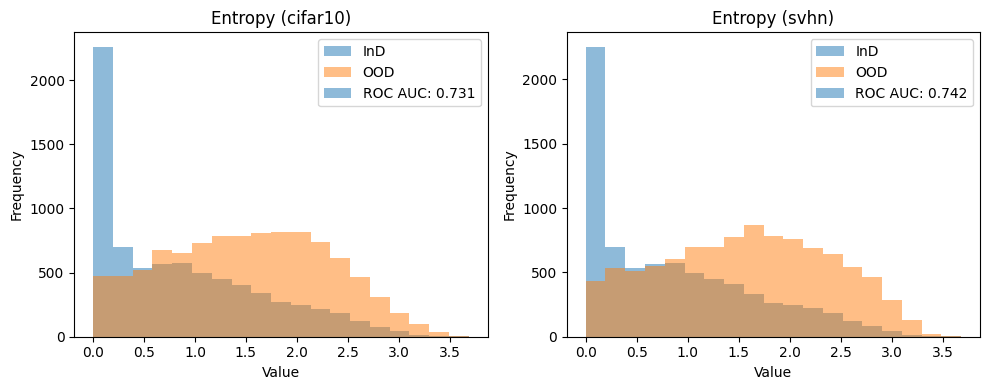

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

roc_auc_cifar10_entropy_single = plot_histogram_eq_width(axs[0], data1=cifar100_entropy_scores, data2=cifar10_entropy_scores, title="Entropy (cifar10)")
roc_auc_svhn_entropy_single = plot_histogram_eq_width(axs[1], data1=cifar100_entropy_scores, data2=svhn_entropy_scores, title="Entropy (svhn)")

plt.tight_layout()
plt.show()

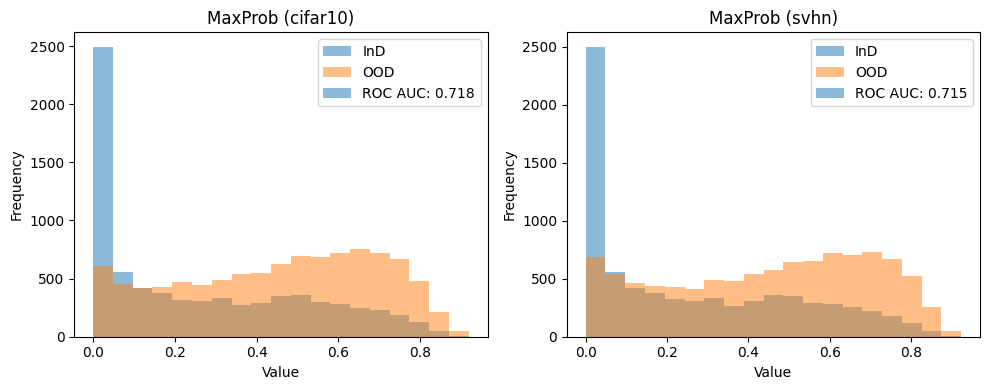

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

roc_auc_cifar10_maxprob_single = plot_histogram_eq_width(axs[0], data1=cifar100_maxprob_scores, data2=cifar10_maxprob_scores, title="MaxProb (cifar10)")
roc_auc_svhn_maxprob_single = plot_histogram_eq_width(axs[1], data1=cifar100_maxprob_scores, data2=svhn_maxprob_scores, title="MaxProb (svhn)")

plt.tight_layout()
plt.show()

## Давайте посмотрим на самые уверенные/неуверенные объекты.

Так как CIFAR10 и CIFAR100 очень похожи, нам будет сложно, глядя на объекты, понять, из какого датасета пришел этот объект.

Поэтому предлагаю посмотреть на CIFAR100 vs SVHN.

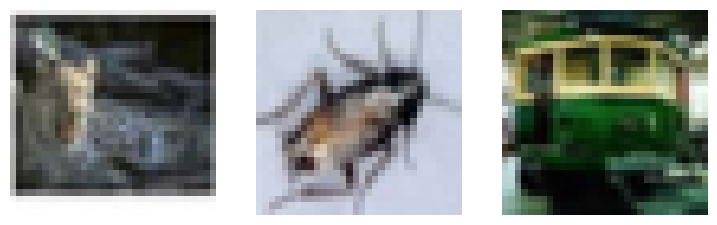

In [17]:
plot_images(dataset=cifar100_valid, indices=np.array([1, 2, 3]))

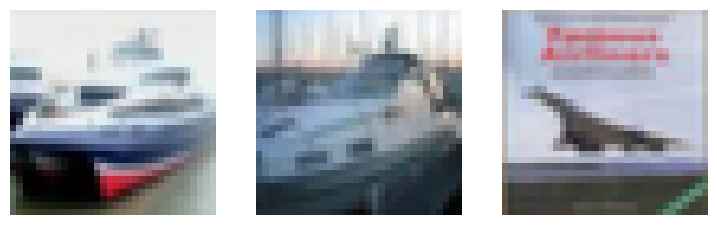

In [18]:
plot_images(dataset=cifar10_valid, indices=np.array([1, 2, 3]))

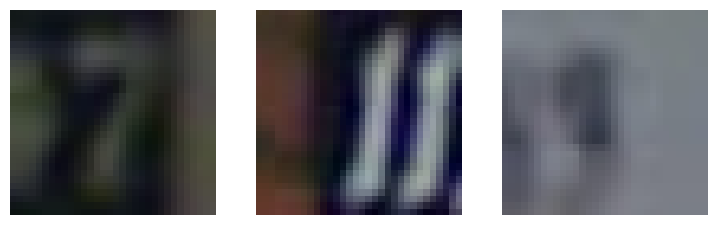

In [19]:
plot_images(dataset=svhn_valid, indices=np.array([1, 2, 3]))

### Найдём топ самых уверенных и неуверенных объектов

In [20]:
def get_extreme_score_indices(scores0: list, scores1: list, k: int, extreme='max'):

    all_scores = np.concatenate((scores0, scores1))

    indices = np.argsort(all_scores)

    if extreme == 'max':
        idxs = indices[-k:]
    elif extreme == 'min':
        idxs = indices[:k]
    else:
        raise ValueError("`extreme` must be either 'min' or 'max'")

    dataset_idxs = (idxs >= len(scores0)) * 1
    within_dataset_idxs = np.where(dataset_idxs == 0, idxs, idxs - len(scores0))

    return dataset_idxs, within_dataset_idxs

По энтропии

In [21]:
dataset_idxs, within_dataset_idxs = get_extreme_score_indices(
    scores0=cifar100_entropy_scores,
    scores1=svhn_entropy_scores,
    k=10, extreme='max'
)

In [22]:
# Какая доля OOD объектов попала в топ k самых неопределённых?
np.mean(dataset_idxs)

0.5

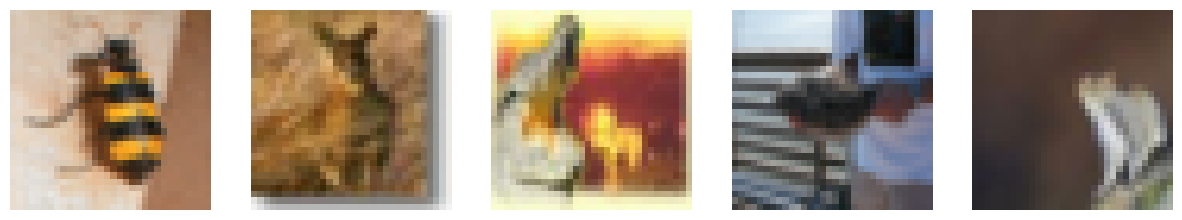

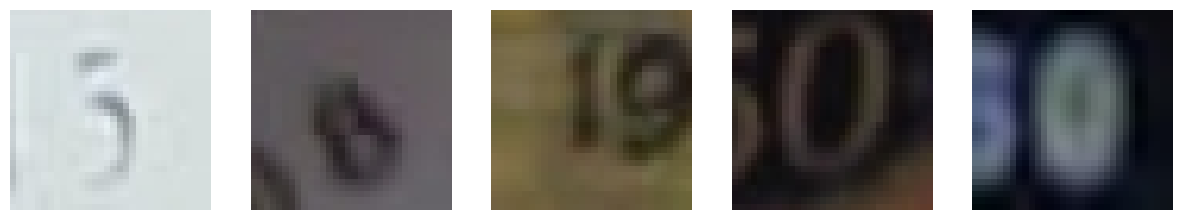

In [23]:
plot_images(dataset=cifar100_valid, indices=within_dataset_idxs[dataset_idxs==0])
plot_images(dataset=svhn_valid, indices=within_dataset_idxs[dataset_idxs==1])

По максимальной вероятности

In [24]:
dataset_idxs, within_dataset_idxs = get_extreme_score_indices(
    scores0=cifar100_maxprob_scores,
    scores1=svhn_maxprob_scores,
    k=10, extreme='max'
)

In [25]:
# Какая доля OOD объектов попала в топ k самых неопределённых?
np.mean(dataset_idxs)

1.0

<Figure size 0x300 with 0 Axes>

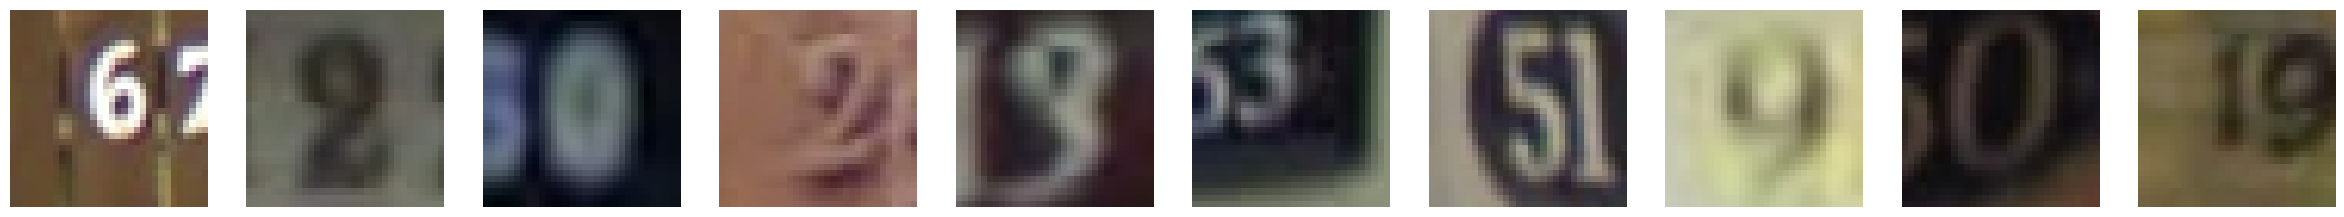

In [26]:
plot_images(dataset=cifar100_valid, indices=within_dataset_idxs[dataset_idxs==0])
plot_images(dataset=svhn_valid, indices=within_dataset_idxs[dataset_idxs==1])

Добавим результаты ROC AUC в словарь. В конце построим сводную табличку и увидим, что работает лучше всего.

In [27]:
RESULTS.append({
    "method": "single model",
    "ood": "cifar10",
    "entropy": roc_auc_cifar10_entropy_single,
    "maxprob": roc_auc_cifar10_maxprob_single
})

In [28]:
RESULTS.append({
    "method": "single model",
    "ood": "svhn",
    "entropy": roc_auc_svhn_entropy_single,
    "maxprob": roc_auc_svhn_maxprob_single
})

In [29]:
RESULTS

[{'method': 'single model',
  'ood': 'cifar10',
  'entropy': 0.731,
  'maxprob': 0.718},
 {'method': 'single model', 'ood': 'svhn', 'entropy': 0.742, 'maxprob': 0.715}]

# Калибровка предсказаний нейросетей

**On Calibration of Modern Neural Networks**

https://proceedings.mlr.press/v70/guo17a/guo17a.pdf

Калибровка предсказаний нейронных сетей — это процесс, в ходе которого корректируется выходной сигнал модели так, чтобы его можно было лучше интерпретировать как вероятность. Это важно, так как во многих приложениях от нейросетей требуется не только предсказать класс, но и указать уровень уверенности в своем прогнозе.


Мы говорим, что модель калибрована, если для всех примеров с предсказанными вероятностями p, истинная вероятность того, что эти примеры принадлежат к классу, который модель предсказывает, также равна p.


Например, если у нас есть 100 примеров, для которых модель предсказывает класс A с вероятностью 0.8, то если модель калибрована, около 80 из этих примеров действительно будут принадлежать к классу A.

Существуют множество способов калибровки, но в данном примере мы рассмотрим самый просто -- температурное шкалирование (temperature scaling).

Идея метода очень проста: сперва мы обучаем нейронную сеть (делаем всё как обычно), а дальше замораживаем её параметры и добавляем новый. Этот новый обучаемый параметр -- температура. Дальше на валидационном сете мы максимизируем правдоподобие, обновляя лишь этот параметр температуры.

Оценить, насколько хорошо откалибрована модель, можно с помощью метрики, называемой ``Expected Calibration Error (ECE)''.

$$
\text{ECE} = \sum_{m=1}^{M} \frac{|B_m|}{n} \left| \text{acc}(B_m) - \text{conf}(B_m) \right|
$$


In [30]:
labels, probs = collect_labels_and_probs(model_=model, dataloader=cifar100_valloader, device=device)

In [31]:
accuracy_score(y_true=labels, y_pred=np.argmax(probs, axis=-1))

0.6844

Для визуализации того, как хорошо откалибрована модель, используют так называемые Reliability Diagrams.

Идея такая -- для каждого объекта из валидационной выборки предсказывается вектор ``вероятностей''. Из них выбираются максимальные и сортируются по возрастанию.

Далее мы разбиваем этот отсортированный массив на ячейки, и внутри каждой считаем accuracy.

/home/nkotelevskii/github/helpers/reliability_diagrams.py:177: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels(new_ticks)


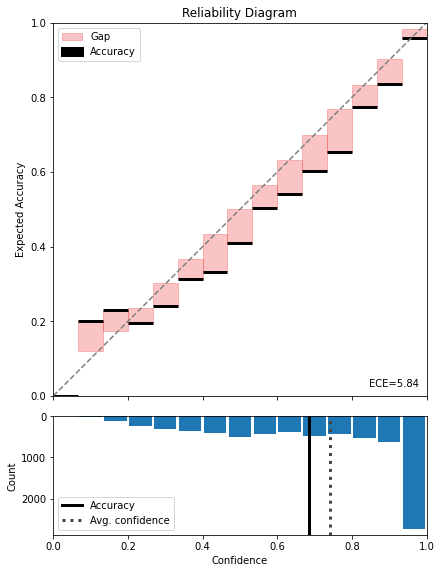

In [32]:
reliability_diagram(
    true_labels=labels,
    pred_labels=np.argmax(probs, axis=-1),
    confidences=probs[np.arange(len(probs)),
                      np.argmax(probs, axis=-1)
                      ],
     num_bins=15
    )

## Попробуем откалибровать нашу модель

Калибровка модели будет осуществлена с помощью Temperature Scaling.

Преимущества этого метода -- он требует обучения всего одного параметра, и достаточно лишь одного прогона через датасет, чтобы хорошо его обучить.

In [33]:
calibrated_model = ModelWithTemperature(deepcopy(model))
calibrated_model.set_temperature(cifar100_calloader)
calibrated_model.eval()
print("OK!")

Before temperature - NLL: 1.189, ECE: 0.066
Optimal temperature: 1.394
After temperature - NLL: 1.154, ECE: 0.040
OK!


In [34]:
labels, calibrated_probs = collect_labels_and_probs(model_=calibrated_model, dataloader=cifar100_valloader, device=device)

In [35]:
accuracy_score(y_true=labels, y_pred=np.argmax(calibrated_probs, axis=-1))

0.6844

/home/nkotelevskii/github/helpers/reliability_diagrams.py:177: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels(new_ticks)


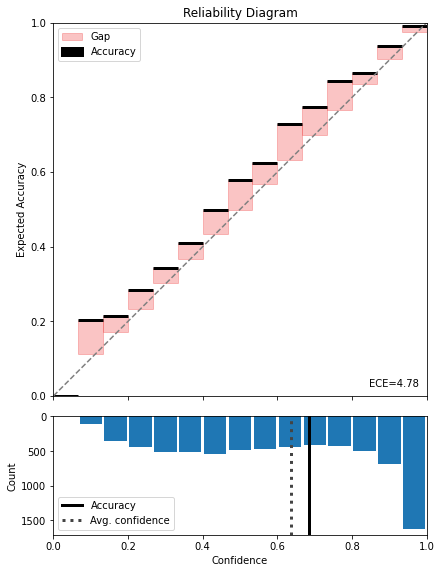

In [36]:
reliability_diagram(
    true_labels=labels,
    pred_labels=np.argmax(calibrated_probs, axis=-1),
    confidences=calibrated_probs[
        np.arange(len(calibrated_probs)),
        np.argmax(calibrated_probs, axis=-1)
                      ],
     num_bins=15
    )

In [37]:
# Compute scores for CIFAR100
cifar100_entropy_scores_cal, cifar100_maxprob_scores_cal = compute_scores(calibrated_model, cifar100_valloader, device)

# Compute scores for OOD datasets
cifar10_entropy_scores_cal, cifar10_maxprob_scores_cal = compute_scores(calibrated_model, cifar10_valloader, device)
svhn_entropy_scores_cal, svhn_maxprob_scores_cal = compute_scores(calibrated_model, svhn_valloader, device)

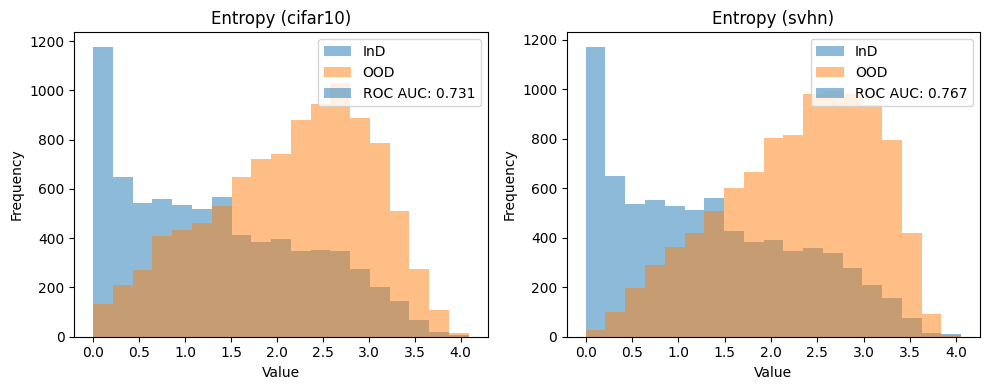

In [38]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

roc_auc_cifar10_entropy_single_cal = plot_histogram_eq_width(axs[0], data1=cifar100_entropy_scores_cal, data2=cifar10_entropy_scores_cal, title="Entropy (cifar10)")
roc_auc_svhn_entropy_single_cal = plot_histogram_eq_width(axs[1], data1=cifar100_entropy_scores_cal, data2=svhn_entropy_scores_cal, title="Entropy (svhn)")

plt.tight_layout()
plt.show()

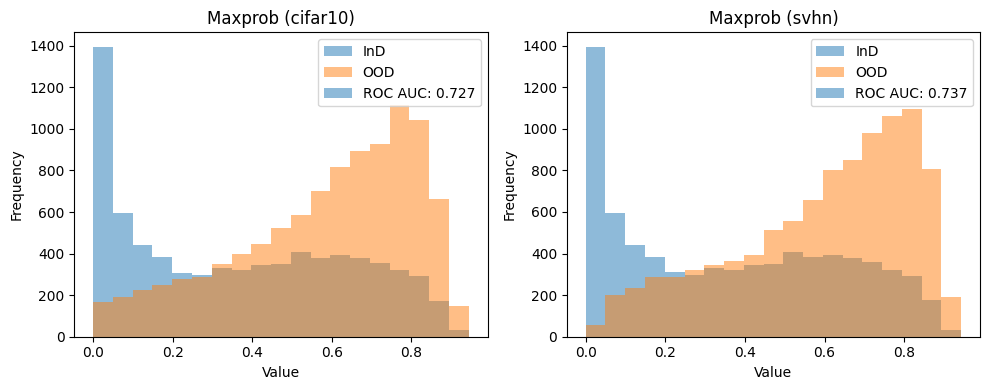

In [39]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

roc_auc_cifar10_maxprob_single_cal = plot_histogram_eq_width(axs[0], data1=cifar100_maxprob_scores_cal, data2=cifar10_maxprob_scores_cal, title="Maxprob (cifar10)")
roc_auc_svhn_maxprob_single_cal = plot_histogram_eq_width(axs[1], data1=cifar100_maxprob_scores_cal, data2=svhn_maxprob_scores_cal, title="Maxprob (svhn)")

plt.tight_layout()
plt.show()

### Топ неопределённых

По энтропии

In [40]:
dataset_idxs, within_dataset_idxs = get_extreme_score_indices(
    scores0=cifar100_entropy_scores_cal,
    scores1=svhn_entropy_scores_cal,
    k=10, extreme='max'
)

In [41]:
# Какая доля OOD объектов попала в топ k самых неопределённых?
np.mean(dataset_idxs)

0.3

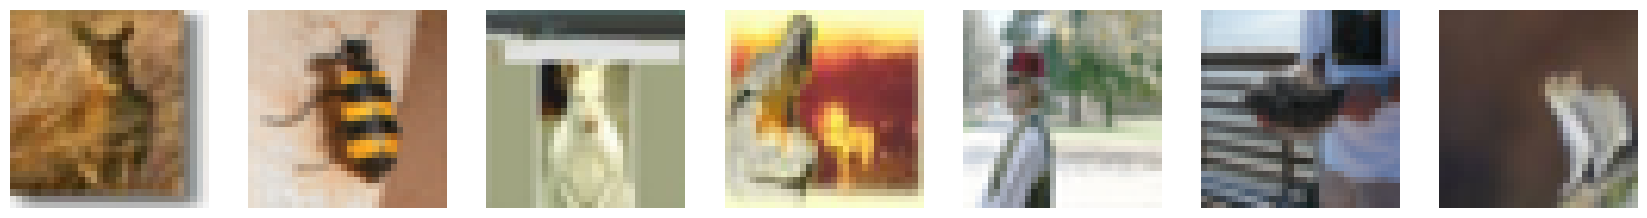

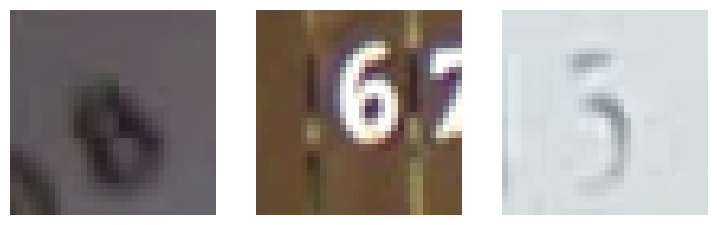

In [42]:
plot_images(dataset=cifar100_valid, indices=within_dataset_idxs[dataset_idxs==0])
plot_images(dataset=svhn_valid, indices=within_dataset_idxs[dataset_idxs==1])

По макспробу

In [43]:
dataset_idxs, within_dataset_idxs = get_extreme_score_indices(
    scores0=cifar100_maxprob_scores_cal,
    scores1=svhn_maxprob_scores_cal,
    k=10, extreme='max'
)

In [44]:
# Какая доля OOD объектов попала в топ k самых неопределённых?
np.mean(dataset_idxs)

0.9

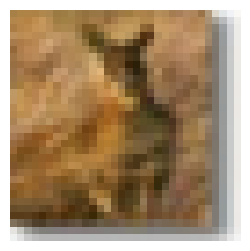

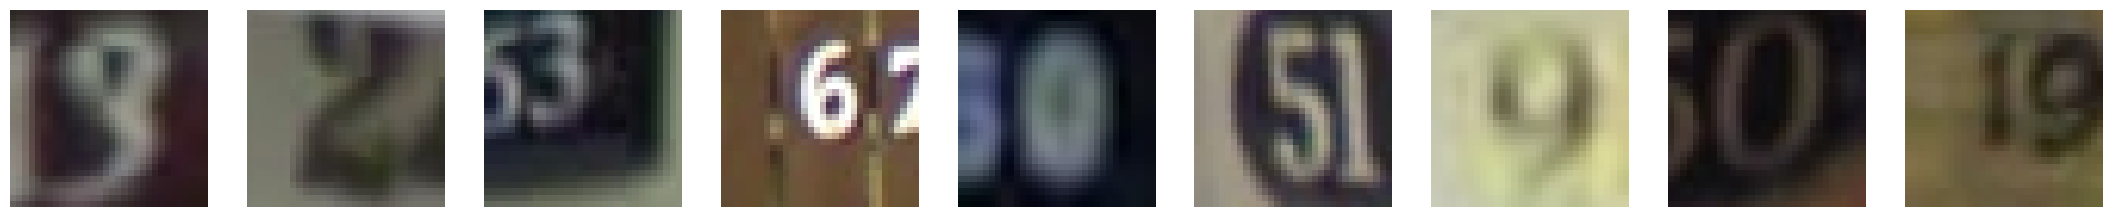

In [45]:
plot_images(dataset=cifar100_valid, indices=within_dataset_idxs[dataset_idxs==0])
plot_images(dataset=svhn_valid, indices=within_dataset_idxs[dataset_idxs==1])

### Вопросы:

Влияет ли калибровка на accuracy?

Что лучше -- overconfidence или underconfidence?

In [46]:
RESULTS.append({
    "method": "single model cal",
    "ood": "cifar10",
    "entropy": roc_auc_cifar10_entropy_single_cal,
    "maxprob": roc_auc_cifar10_maxprob_single_cal
})

In [47]:
RESULTS.append({
    "method": "single model cal",
    "ood": "svhn",
    "entropy": roc_auc_svhn_entropy_single_cal,
    "maxprob": roc_auc_svhn_maxprob_single_cal
})

# Ансамбли нейронных сетей (Deep emsembles)

https://proceedings.neurips.cc/paper_files/paper/2017/file/9ef2ed4b7fd2c810847ffa5fa85bce38-Paper.pdf

Lakshminarayanan B., Pritzel A., Blundell C. Simple and scalable predictive uncertainty estimation using deep ensembles //Advances in neural information processing systems. – 2017. – Т. 30.


Как мы разобрали на лекции, использование ансамблей может быть рассмотрено как метод приближенного Байесовского вывода.

А именно:

Если у нас есть апостериорное распределение на параметры модели, $p(\theta \mid D_{\text{tr}})$, то веса членов ансамбля могут быть рассмотрены как сэмплы из этого распределения.

Напомним, что обычно предсказательное апостериорное распределение получается вот так:

$$
p(y \mid x, D_{\text{tr}}) = \int_{\theta} p(y \mid x, \theta)p(\theta \mid D_{\text{tr}}) d\theta,
$$

и этот интеграл на практике посчитать очень сложно (или даже невозможно, за исключением особых случаев). Поэтому его обычно аппроксимируют с помощью так называемой оценки Монте-Карло:

$$
p(y \mid x, D_{\text{tr}}) \approx \frac{1}{K} \sum_{k=1}^K p(y \mid x, \theta_k),
$$
где $\theta_k \sim p(\theta \mid D_{\text{tr}})$.

И это именно то, как на практике получаются предсказания для ансамблей!

In [48]:
# Загрузим ансамбли
ensemble = load_emsembles(device=device)

In [49]:
# Вопрос -- сколько моделей в ансамбле у нас есть?

In [50]:
labels, ensemble_probs = collect_labels_and_probs_ensemble(ensemble_=ensemble, dataloader=cifar100_valloader, device=device)

In [51]:
# Точность у ансамбля заметно выше, чем у одиночной модели!
accuracy_score(y_true=labels, y_pred=np.argmax(ensemble_probs, axis=-1))

0.7586666666666667

/home/nkotelevskii/github/helpers/reliability_diagrams.py:177: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels(new_ticks)


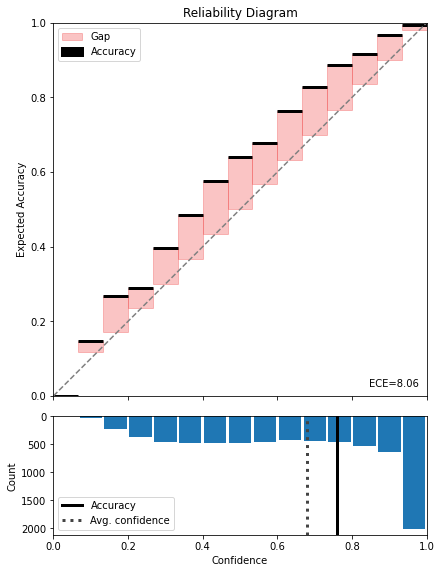

In [52]:
reliability_diagram(
    true_labels=labels,
    pred_labels=np.argmax(ensemble_probs, axis=-1),
    confidences=ensemble_probs[
        np.arange(len(ensemble_probs)),
        np.argmax(ensemble_probs, axis=-1)
                      ],
     num_bins=15
    )

In [53]:
# Compute scores for CIFAR100
cifar100_EH_ensemble, cifar100_HE_ensemble, cifar100_maxprob_ensemble = compute_scores_ensemble(ensemble, cifar100_valloader, device)

# Compute scores for OOD
cifar10_EH_ensemble, cifar10_HE_ensemble, cifar10_maxprob_ensemble = compute_scores_ensemble(ensemble, cifar10_valloader, device)
svhn_EH_ensemble, svhn_HE_ensemble, svhn_maxprob_ensemble = compute_scores_ensemble(ensemble, svhn_valloader, device)

Одно из преимуществ Байесовских методов заключается в том, что у нас есть возможность получать несколько сэмплов весов. Это открывает для нас окно возможностей при подсчёте метрик неопредлённости.

Действительно, имея несколько различных сэмплов весов (другими словами несколько моделей), мы можем каким-то образом учесть их согласованность / не согласованность друг с другом, и заложить это в метрики неопределённости.


Для байесовских (и подобных им) моделей мы будем использовать следующие метрики:

- $\mathcal{H}\mathbb{E} p(y \mid x, \theta) = \mathcal{H} p(y \mid x, D_{\text{tr}})$ -- энтропия предсказанного апостериорного распределения. Она содержит в себе всю неопределённость.

- $\mathbb{E} \mathcal{H} p(y \mid x, \theta)$ -- ожидаемая энтропия. По факту, это средняя алеаторная неопределённость по членам ансамбля.

- $\mathcal{H}\mathbb{E} p(y \mid x, \theta) - \mathbb{E} \mathcal{H} p(y \mid x, \theta)$ -- разница между ними. Так как первый член -- это полная неопредённость, а второй -- только алеаторная, то разница является мерой эпистемической неопределённости. В литературе эту разница называют BALD.

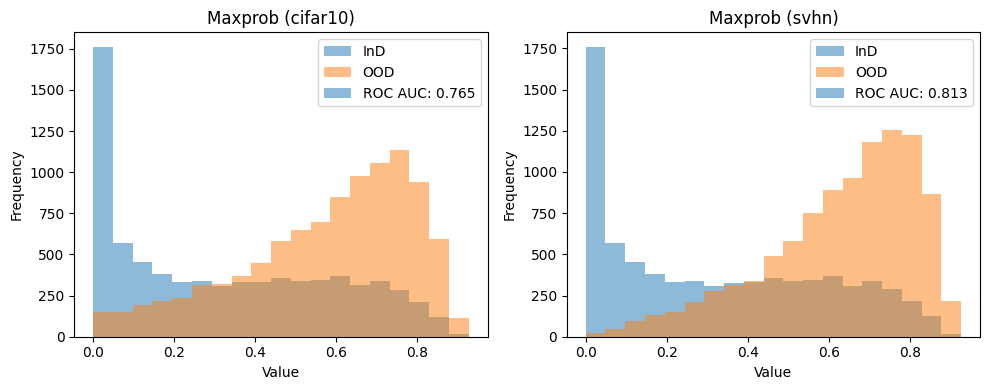

In [54]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

roc_auc_cifar10_maxprob_ensemble = plot_histogram_eq_width(axs[0], data1=cifar100_maxprob_ensemble, data2=cifar10_maxprob_ensemble, title="Maxprob (cifar10)")
roc_auc_svhn_maxprob_ensemble = plot_histogram_eq_width(axs[1], data1=cifar100_maxprob_ensemble, data2=svhn_maxprob_ensemble, title="Maxprob (svhn)")

plt.tight_layout()
plt.show()

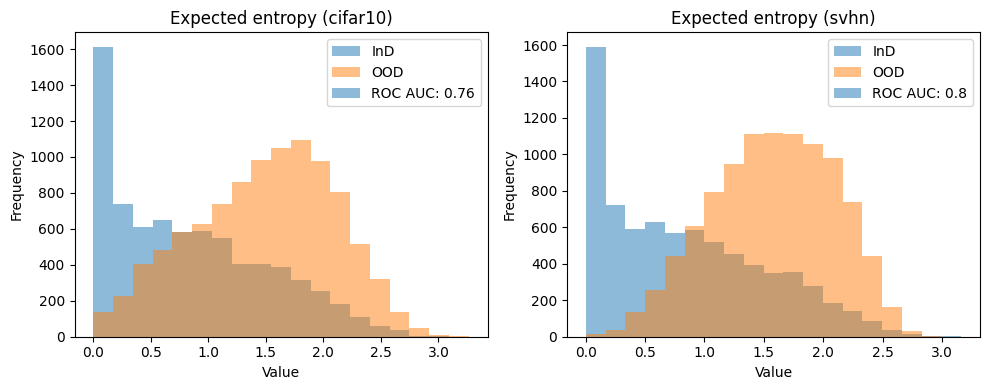

In [55]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

roc_auc_cifar10_EH_ensemble = plot_histogram_eq_width(axs[0], data1=cifar100_EH_ensemble, data2=cifar10_EH_ensemble, title="Expected entropy (cifar10)")
roc_auc_svhn_EH_ensemble = plot_histogram_eq_width(axs[1], data1=cifar100_EH_ensemble, data2=svhn_EH_ensemble, title="Expected entropy (svhn)")

plt.tight_layout()
plt.show()

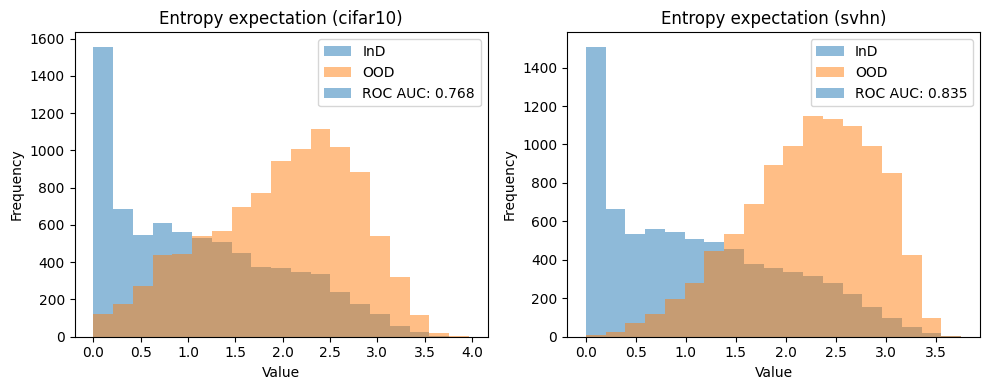

In [56]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

roc_auc_cifar10_HE_ensemble = plot_histogram_eq_width(axs[0], data1=cifar100_HE_ensemble, data2=cifar10_HE_ensemble, title="Entropy expectation (cifar10)")
roc_auc_svhn_HE_ensemble = plot_histogram_eq_width(axs[1], data1=cifar100_HE_ensemble, data2=svhn_HE_ensemble, title="Entropy expectation (svhn)")

plt.tight_layout()
plt.show()

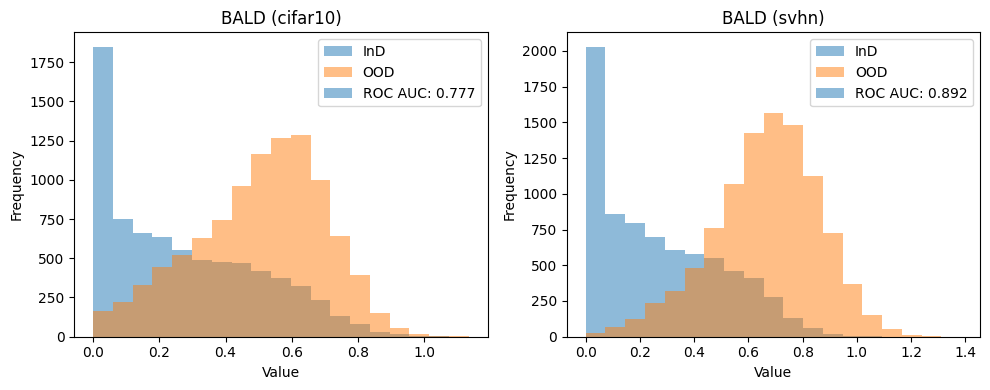

In [57]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

roc_auc_cifar10_BALD_ensemble = plot_histogram_eq_width(axs[0],
                                                      data1=np.array(cifar100_HE_ensemble) - np.array(cifar100_EH_ensemble),
                                                      data2=np.array(cifar10_HE_ensemble) - np.array(cifar10_EH_ensemble),
                                                      title="BALD (cifar10)")

roc_auc_svhn_BALD_ensemble = plot_histogram_eq_width(axs[1],
                                                   data1=np.array(cifar100_HE_ensemble) - np.array(cifar100_EH_ensemble),
                                                   data2=np.array(svhn_HE_ensemble) - np.array(svhn_EH_ensemble),
                                                   title="BALD (svhn)")

plt.tight_layout()
plt.show()

Как и ожидалось, меры неопределённости, ассоциированные с эпистемической и полной неопределённостями, справляются с задачей поиска out-of-distribution данных гораздо лучше, чем меры для алеаторной неопределённости.

Это показывает важность разделения типов неопределённости для разных методов.

### Посмотрим на топ неопределённых предсказаний

По BALD

In [58]:
dataset_idxs, within_dataset_idxs = get_extreme_score_indices(
    scores0=np.array(cifar100_HE_ensemble) - np.array(cifar100_EH_ensemble),
    scores1=np.array(svhn_HE_ensemble) - np.array(svhn_EH_ensemble),
    k=10, extreme='max'
)

In [59]:
# Какая доля OOD объектов попала в топ k самых неопределённых?
np.mean(dataset_idxs)

1.0

<Figure size 0x300 with 0 Axes>

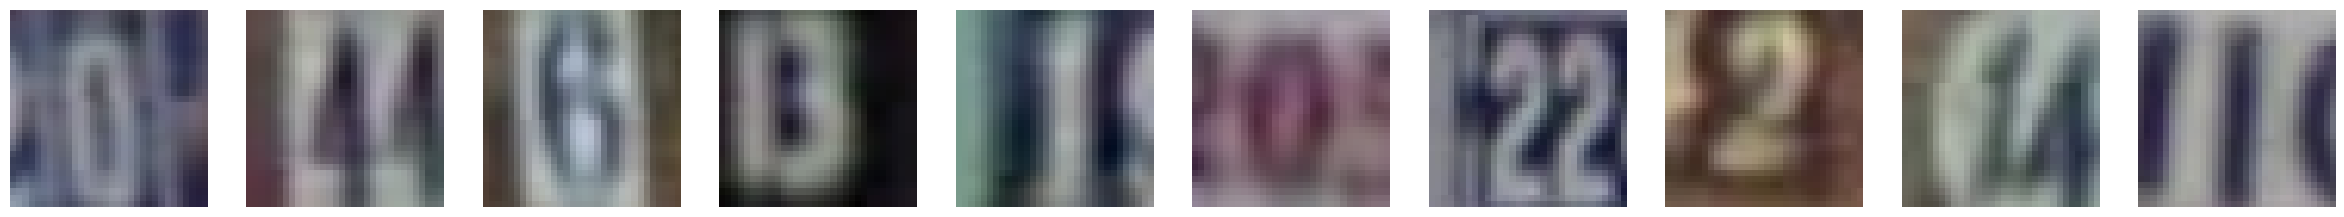

In [60]:
plot_images(dataset=cifar100_valid, indices=within_dataset_idxs[dataset_idxs==0])
plot_images(dataset=svhn_valid, indices=within_dataset_idxs[dataset_idxs==1])

По ожидаемой энтропии

In [61]:
dataset_idxs, within_dataset_idxs = get_extreme_score_indices(
    scores0=np.array(cifar100_EH_ensemble),
    scores1=np.array(svhn_EH_ensemble),
    k=10, extreme='max'
)

In [62]:
# Какая доля OOD объектов попала в топ k самых неопределённых?
np.mean(dataset_idxs)

0.3

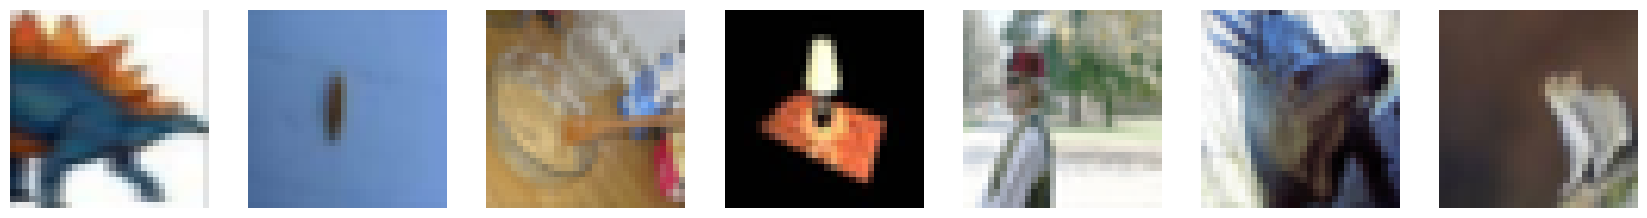

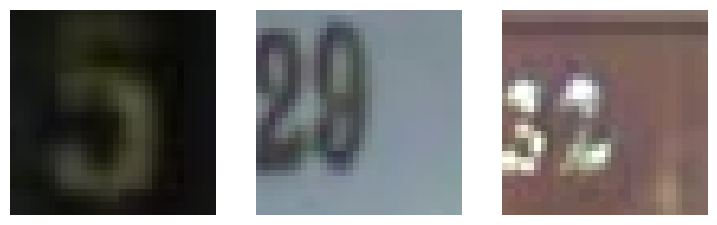

In [63]:
plot_images(dataset=cifar100_valid, indices=within_dataset_idxs[dataset_idxs==0])
plot_images(dataset=svhn_valid, indices=within_dataset_idxs[dataset_idxs==1])

In [64]:
RESULTS.append({
    "method": "ensemble",
    "ood": "cifar10",
    "HE": roc_auc_cifar10_HE_ensemble,
    "EH": roc_auc_cifar10_EH_ensemble,
    "BALD": roc_auc_cifar10_BALD_ensemble,
    "maxprob": roc_auc_cifar10_maxprob_ensemble
})

In [65]:
RESULTS.append({
    "method": "ensemble",
    "ood": "svhn",
    "HE": roc_auc_svhn_HE_ensemble,
    "EH": roc_auc_svhn_EH_ensemble,
    "BALD": roc_auc_svhn_BALD_ensemble,
    "maxprob": roc_auc_svhn_maxprob_ensemble
})

## Давайте откалибруем каждую модель в ансамбле !

Мы увидели, что калибрация одной модели уменьшает ECE, а так же ведём к улучшению OOD детекции.

Идея -- а давайте откалибруем каждую модель в ансамбле. Может быть тогда ECE уменьшится, а OOD детекция станет ещё лучше?

Как вы думаете, что будет с ECE?

Интуиция такая -- мы калибруем каждую модель и эффективно приводим к одним единицам измерения (настоящим вероятностям). Соответственно и ансамбль в целом будет откалиброван лучше...



In [66]:
calibrated_ensemble = ensemble_calibration(ensemble=ensemble, calloader=cifar100_calloader)

Before temperature - NLL: 1.200, ECE: 0.075
Optimal temperature: 1.409
After temperature - NLL: 1.156, ECE: 0.031
Before temperature - NLL: 1.183, ECE: 0.073
Optimal temperature: 1.390
After temperature - NLL: 1.152, ECE: 0.035
Before temperature - NLL: 1.189, ECE: 0.066
Optimal temperature: 1.394
After temperature - NLL: 1.154, ECE: 0.040
Before temperature - NLL: 1.205, ECE: 0.072
Optimal temperature: 1.399
After temperature - NLL: 1.166, ECE: 0.035
Before temperature - NLL: 1.178, ECE: 0.068
Optimal temperature: 1.377
After temperature - NLL: 1.155, ECE: 0.041
Before temperature - NLL: 1.202, ECE: 0.072
Optimal temperature: 1.400
After temperature - NLL: 1.163, ECE: 0.033
Before temperature - NLL: 1.174, ECE: 0.062
Optimal temperature: 1.385
After temperature - NLL: 1.145, ECE: 0.045
Before temperature - NLL: 1.164, ECE: 0.074
Optimal temperature: 1.387
After temperature - NLL: 1.134, ECE: 0.030
Before temperature - NLL: 1.195, ECE: 0.069
Optimal temperature: 1.399
After temperature

In [67]:
labels, calibrated_ensemble_probs = collect_labels_and_probs_ensemble(ensemble_=calibrated_ensemble, dataloader=cifar100_valloader, device=device)

Вопрос: Поменяется ли точность ансамбля после калибрации каждого из его членов?


В случае одной модели ничего не менялось. А тут?

In [68]:
accuracy_score(y_true=labels, y_pred=np.argmax(calibrated_ensemble_probs, axis=-1))

0.7574666666666666

/home/nkotelevskii/github/helpers/reliability_diagrams.py:177: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels(new_ticks)


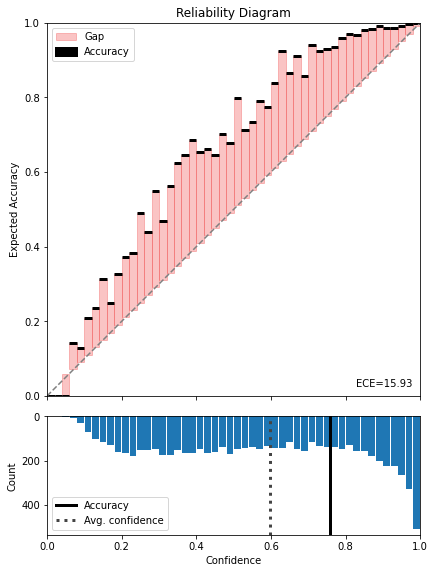

In [69]:
reliability_diagram(
    true_labels=labels,
    pred_labels=np.argmax(calibrated_ensemble_probs, axis=-1),
    confidences=calibrated_ensemble_probs[
        np.arange(len(calibrated_ensemble_probs)),
        np.argmax(calibrated_ensemble_probs, axis=-1)
                      ],
     num_bins=15
    )

Оказывается, калибровка каждого члена ансамбля **не ведёт к тому**, что сам ансамбль будет откалиброван.

Напротив, ансамбль становится underconfident -- то есть он назначает вероятности ниже, чем ожидаемая точность.


Этот эффект известен, и описан например здесь:
https://arxiv.org/pdf/2101.05397.pdf

Давайте посчитаем меры неопределённости...

In [70]:
# Compute scores for CIFAR100
cifar100_EH_cal_ensemble, cifar100_HE_cal_ensemble, cifar100_maxprob_cal_ensemble = compute_scores_ensemble(calibrated_ensemble, cifar100_valloader, device)

# Compute scores for OOD
cifar10_EH_cal_ensemble, cifar10_HE_cal_ensemble, cifar10_maxprob_cal_ensemble = compute_scores_ensemble(calibrated_ensemble, cifar10_valloader, device)
svhn_EH_cal_ensemble, svhn_HE_cal_ensemble, svhn_maxprob_cal_ensemble = compute_scores_ensemble(calibrated_ensemble, svhn_valloader, device)

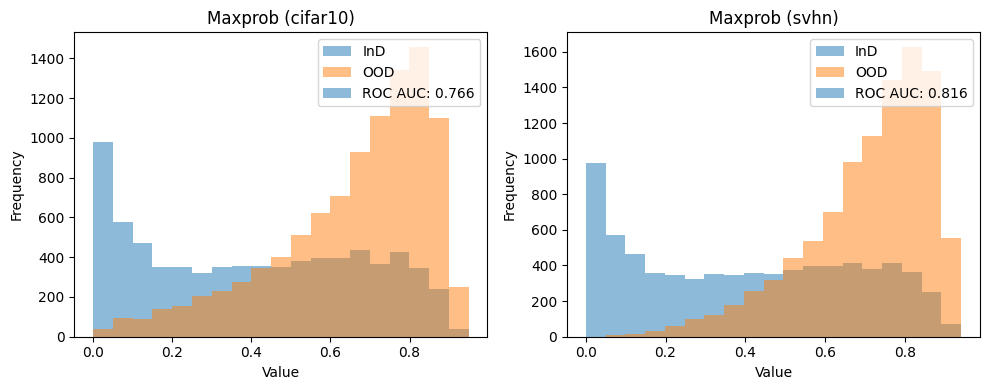

In [71]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

roc_auc_cifar10_maxprob_ensemble_cal = plot_histogram_eq_width(axs[0], data1=cifar100_maxprob_cal_ensemble, data2=cifar10_maxprob_cal_ensemble, title="Maxprob (cifar10)")
roc_auc_svhn_maxprob_ensemble_cal = plot_histogram_eq_width(axs[1], data1=cifar100_maxprob_cal_ensemble, data2=svhn_maxprob_cal_ensemble, title="Maxprob (svhn)")

plt.tight_layout()
plt.show()

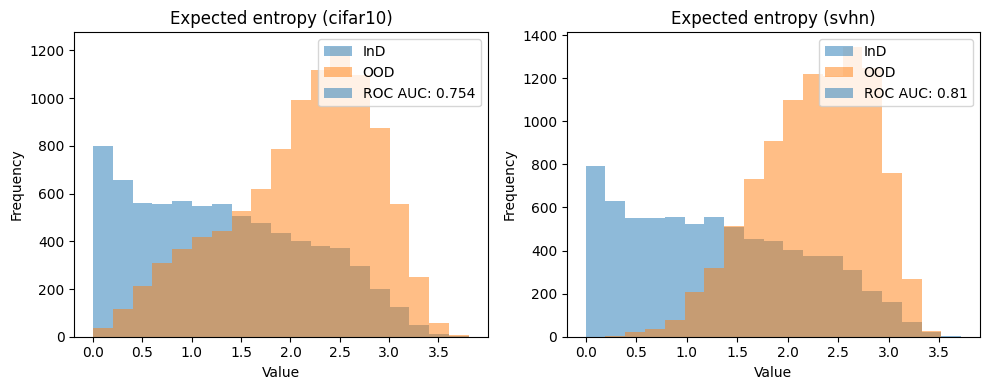

In [72]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

roc_auc_cifar10_EH_ensemble_cal = plot_histogram_eq_width(axs[0], data1=cifar100_EH_cal_ensemble, data2=cifar10_EH_cal_ensemble, title="Expected entropy (cifar10)")
roc_auc_svhn_EH_ensemble_cal = plot_histogram_eq_width(axs[1], data1=cifar100_EH_cal_ensemble, data2=svhn_EH_cal_ensemble, title="Expected entropy (svhn)")

plt.tight_layout()
plt.show()

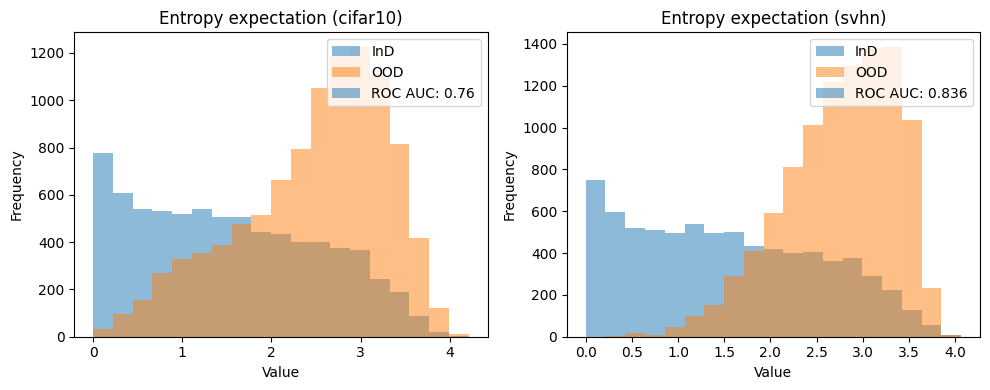

In [73]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

roc_auc_cifar10_HE_ensemble_cal = plot_histogram_eq_width(axs[0], data1=cifar100_HE_cal_ensemble, data2=cifar10_HE_cal_ensemble, title="Entropy expectation (cifar10)")
roc_auc_svhn_HE_ensemble_cal = plot_histogram_eq_width(axs[1], data1=cifar100_HE_cal_ensemble, data2=svhn_HE_cal_ensemble, title="Entropy expectation (svhn)")

plt.tight_layout()
plt.show()

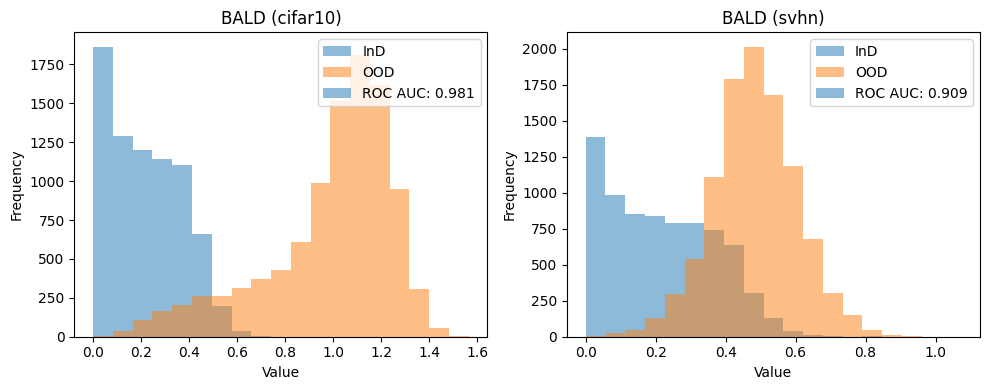

In [74]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

roc_auc_cifar10_BALD_ensemble_cal = plot_histogram_eq_width(axs[0],
                                                      data1=np.array(cifar100_HE_cal_ensemble) - np.array(cifar100_EH_cal_ensemble),
                                                      data2=np.array(cifar10_HE_cal_ensemble) - np.array(cifar10_EH_ensemble),
                                                      title="BALD (cifar10)")

roc_auc_svhn_BALD_ensemble_cal = plot_histogram_eq_width(axs[1],
                                                   data1=np.array(cifar100_HE_cal_ensemble) - np.array(cifar100_EH_cal_ensemble),
                                                   data2=np.array(svhn_HE_cal_ensemble) - np.array(svhn_EH_cal_ensemble),
                                                   title="BALD (svhn)")

plt.tight_layout()
plt.show()

Видно, что калибрация, при этом, заметно улучшила OOD детекцию. На CIFAR10 для BALD результат получился неожиданно хорошим!

### Топ неопределённых

In [75]:
dataset_idxs, within_dataset_idxs = get_extreme_score_indices(
    scores0=np.array(cifar100_HE_cal_ensemble) - np.array(cifar100_EH_cal_ensemble),
    scores1=np.array(svhn_HE_cal_ensemble) - np.array(svhn_EH_cal_ensemble),
    k=10, extreme='max'
)

In [76]:
# Какая доля OOD объектов попала в топ k самых неопределённых?
np.mean(dataset_idxs)

1.0

<Figure size 0x300 with 0 Axes>

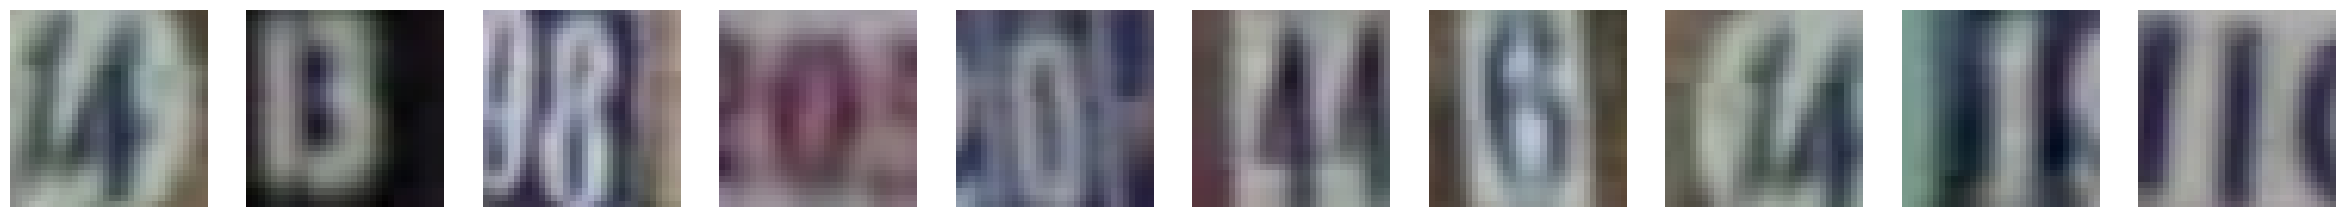

In [77]:
plot_images(dataset=cifar100_valid, indices=within_dataset_idxs[dataset_idxs==0])
plot_images(dataset=svhn_valid, indices=within_dataset_idxs[dataset_idxs==1])

In [78]:
RESULTS.append({
    "method": "ensemble cal",
    "ood": "cifar10",
    "HE": roc_auc_cifar10_HE_ensemble_cal,
    "EH": roc_auc_cifar10_EH_ensemble_cal,
    "BALD": roc_auc_cifar10_BALD_ensemble_cal,
    "maxprob": roc_auc_cifar10_maxprob_ensemble_cal
})

In [79]:
RESULTS.append({
    "method": "ensemble cal",
    "ood": "svhn",
    "HE": roc_auc_svhn_HE_ensemble_cal,
    "EH": roc_auc_svhn_EH_ensemble_cal,
    "BALD": roc_auc_svhn_BALD_ensemble_cal,
    "maxprob": roc_auc_svhn_maxprob_ensemble_cal
})

# Monte-Carlo Dropout

http://proceedings.mlr.press/v48/gal16.pdf

Gal, Yarin, and Zoubin Ghahramani. "Dropout as a bayesian approximation: Representing model uncertainty in deep learning." international conference on machine learning. PMLR, 2016.

Как мы обсуждали на лекции, Dropout в нейронных сетях может быть рассмотрен как особое вариационное семейство. Оказывается, тренировка нейросети с дропаутом при добавлении особой l2-регуляризации эквивалентна вариационному выводу.

Вариационное семейство в случае дропаута выглядит вот так:

$$
\Theta_i = M_i \text{diag}(z_{i, j})_{j=1}^K,
$$
$$
z_{i, j} = \text{Bernoulli}(p_i),
$$
где $p_i$ параметр дропаута.

Давайте посмотрим, как хороша эта модель с точки зрения точности и предсказания OOD.

In [80]:
model_drop_conf = PreResNet20Drop()
model_drop = model_drop_conf.base(*model_drop_conf.args, num_classes=100, **model_drop_conf.kwargs)
model_drop.load_state_dict(torch.load(f'./preresnetdrop20-0.pth'))
model_drop = model_drop.to(device)
#
# model.eval()
model.train()
#
print("OK!")

OK!


In [81]:
N_MC_DROP_SAMPLES = 20

In [82]:
labels, probs_mcdropout = collect_labels_and_probs_mcdropout(mc_model=model_drop,
                                                             dataloader=cifar100_valloader,
                                                             n_samples=N_MC_DROP_SAMPLES, device=device)

/home/nkotelevskii/github/helpers/reliability_diagrams.py:177: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels(new_ticks)


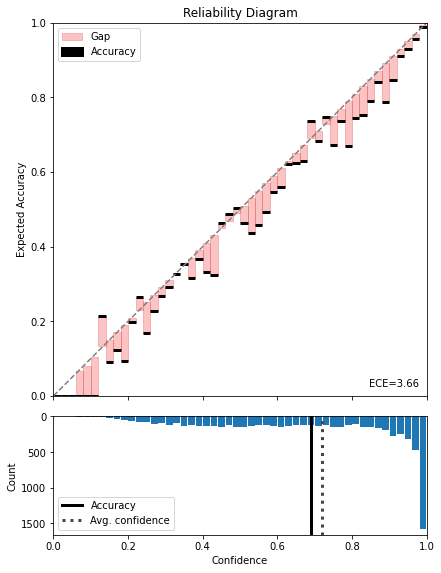

In [83]:
reliability_diagram(
    true_labels=labels,
    pred_labels=np.argmax(probs_mcdropout, axis=-1),
    confidences=probs_mcdropout[
        np.arange(len(probs_mcdropout)),
        np.argmax(probs_mcdropout, axis=-1)
                      ],
     num_bins=15
    )

In [84]:
# Compute scores for CIFAR100
cifar100_EH_mcdrop, cifar100_HE_mcdrop, cifar100_maxprob_mcdrop = compute_scores_mcdropout(
    model_drop, cifar100_valloader, N_MC_DROP_SAMPLES, device)

# Compute scores for OOD
cifar10_EH_mcdrop, cifar10_HE_mcdrop, cifar10_maxprob_mcdrop = compute_scores_mcdropout(
    model_drop, cifar10_valloader, N_MC_DROP_SAMPLES, device)

svhn_EH_mcdrop, svhn_HE_mcdrop, svhn_maxprob_mcdrop = compute_scores_mcdropout(
    model_drop, svhn_valloader, N_MC_DROP_SAMPLES, device)

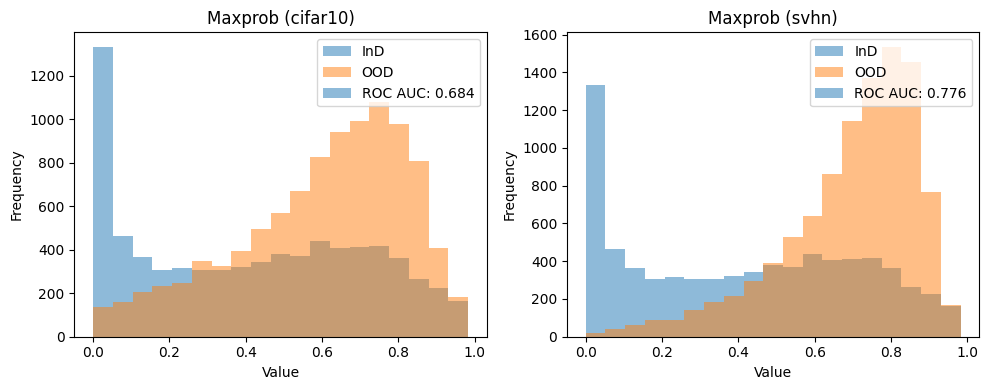

In [85]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

roc_auc_cifar10_maxprob_mcdropout = plot_histogram_eq_width(axs[0], data1=cifar100_maxprob_mcdrop, data2=cifar10_maxprob_mcdrop, title="Maxprob (cifar10)")
roc_auc_svhn_maxprob_mcdropout = plot_histogram_eq_width(axs[1], data1=cifar100_maxprob_mcdrop, data2=svhn_maxprob_mcdrop, title="Maxprob (svhn)")

plt.tight_layout()
plt.show()

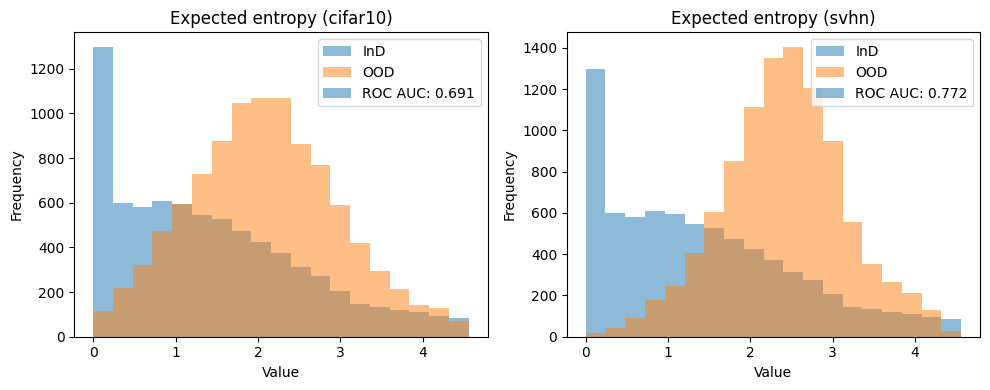

In [86]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

roc_auc_cifar10_EH_mcdropout = plot_histogram_eq_width(axs[0], data1=cifar100_EH_mcdrop, data2=cifar10_EH_mcdrop, title="Expected entropy (cifar10)")
roc_auc_svhn_EH_mcdropout = plot_histogram_eq_width(axs[1], data1=cifar100_EH_mcdrop, data2=svhn_EH_mcdrop, title="Expected entropy (svhn)")

plt.tight_layout()
plt.show()

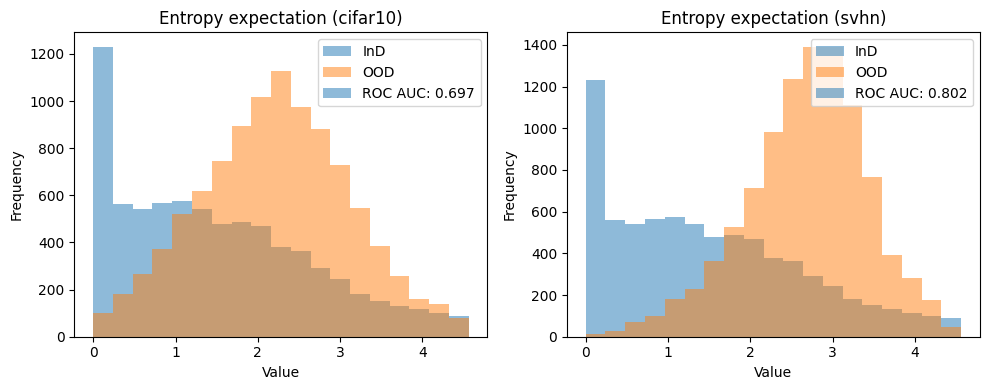

In [87]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

roc_auc_cifar10_HE_mcdropout = plot_histogram_eq_width(axs[0], data1=cifar100_HE_mcdrop, data2=cifar10_HE_mcdrop, title="Entropy expectation (cifar10)")
roc_auc_svhn_HE_mcdropout = plot_histogram_eq_width(axs[1], data1=cifar100_HE_mcdrop, data2=svhn_HE_mcdrop, title="Entropy expectation (svhn)")

plt.tight_layout()
plt.show()

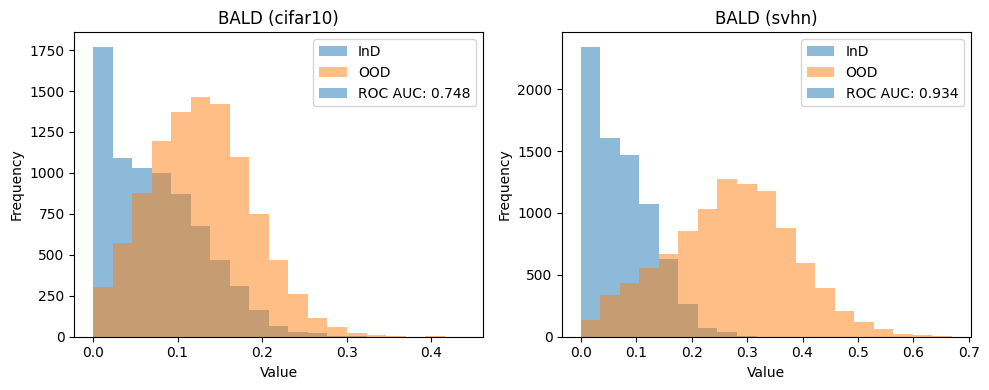

In [88]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

roc_auc_cifar10_BALD_mcdropout = plot_histogram_eq_width(axs[0],
                                                      data1=np.array(cifar100_HE_mcdrop) - np.array(cifar100_EH_mcdrop),
                                                      data2=np.array(cifar10_HE_mcdrop) - np.array(cifar10_EH_mcdrop),
                                                      title="BALD (cifar10)")

roc_auc_svhn_BALD_mcdropout = plot_histogram_eq_width(axs[1],
                                                   data1=np.array(cifar100_HE_mcdrop) - np.array(cifar100_EH_mcdrop),
                                                   data2=np.array(svhn_HE_mcdrop) - np.array(svhn_EH_mcdrop),
                                                   title="BALD (svhn)")

plt.tight_layout()
plt.show()

MC Dropout неплохо себя показал. Одним из его преимуществ является то, что метод очень прост и в обучении, и в применении.

Достаточно лишь переключить слои дропаута в режим тренировки в момент предсказания, и просто собирать получившиеся предсказания. 

### Топ неопределённых

In [91]:
dataset_idxs, within_dataset_idxs = get_extreme_score_indices(
    scores0=np.array(cifar100_HE_mcdrop) - np.array(cifar100_EH_mcdrop),
    scores1=np.array(svhn_HE_mcdrop) - np.array(svhn_EH_mcdrop),
    k=10, extreme='max'
)

In [92]:
# Какая доля OOD объектов попала в топ k самых неопределённых?
np.mean(dataset_idxs)

1.0

<Figure size 0x300 with 0 Axes>

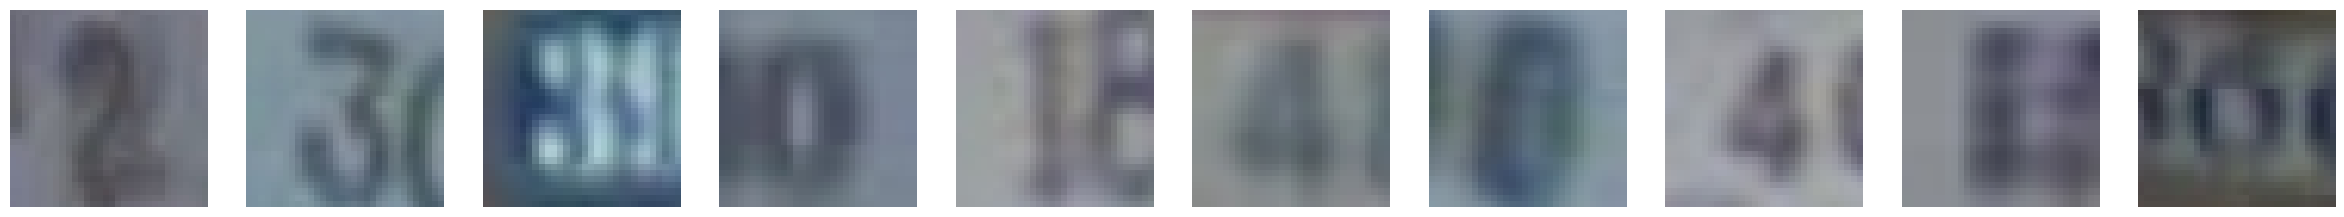

In [93]:
plot_images(dataset=cifar100_valid, indices=within_dataset_idxs[dataset_idxs==0])
plot_images(dataset=svhn_valid, indices=within_dataset_idxs[dataset_idxs==1])

In [89]:
RESULTS.append({
    "method": "mcdropout",
    "ood": "cifar10",
    "HE": roc_auc_cifar10_HE_mcdropout,
    "EH": roc_auc_cifar10_EH_mcdropout,
    "BALD": roc_auc_cifar10_BALD_mcdropout,
    "maxprob": roc_auc_cifar10_maxprob_mcdropout
})

In [90]:
RESULTS.append({
    "method": "mcdropout",
    "ood": "svhn",
    "HE": roc_auc_svhn_HE_mcdropout,
    "EH": roc_auc_svhn_EH_mcdropout,
    "BALD": roc_auc_svhn_BALD_mcdropout,
    "maxprob": roc_auc_svhn_maxprob_mcdropout
})

# Stochastic Weight Averaging Gaussian (SWAG)

https://arxiv.org/pdf/1902.02476.pdf

Maddox, Wesley J., et al. "A simple baseline for bayesian uncertainty in deep learning." Advances in neural information processing systems 32 (2019).

![SWAG](./pics/nswapytorch2.jpg)

Примером модели, не являющеся байесовской с формальной точки зрения, однако вдохновлённой идеями из неё, является Stochastic Weight Averaging Gaussian (SWAG).

Идея довольно простая -- запускаем процесс тренировки нейросети как обычно. Далее, в момент, когда мы сошлись к какой-то моде, снижаем learning rate и начинаем записывать сэмплы весов. 

После этого с помощью полученных сэмплов мы вычисляем среднее и ковариацию весов, и используем их для того, чтобы приблизить моду апостериорного распределения в виде Гауссовского распределения. Подобние идеи встречаются в Лапласовской аппроксимации.

Получив вариационное распределение, мы сэмплим веса из него, что даёт нам возможность использовать все те метрики для оценки неопределённости, которые мы обсудили выше.

Однако тут есть особенность. Если в модели есть слои батч нормализационные слои (а они есть), для каждого сэмпла весов нужно делать дополнительный прогон через тренировочный датасет. Иначе параметры батч нормализации будут неправильными. Это делает метод несколько тяжеловатым с вычислительной точки зрения. Однако нам не обязательно использовать для настройки батч нормализации весь тренировочный датасет. Можно обойтись лишь репрезентативным сэмплом из него!

In [94]:
model_conf = PreResNet20()
base_model = model_conf.base

In [95]:
swag_model = SWAG(base=base_model)

In [96]:
swag_model = SWAG(
    model_conf.base,
    no_cov_mat=False,
    max_num_models=20,
    *model_conf.args,
    num_classes=100,
    **model_conf.kwargs
).to(device)

In [97]:
swag_model.load_state_dict(torch.load('./swag-300.pt', map_location=device)['state_dict'])

In [98]:
N_SWAG_SAMPLES = 20

In [99]:
labels, probs_swag = collect_labels_and_probs_swag(swag_model_=swag_model,
                                                 dataloader=cifar100_valloader, trainloader=cifar100_calloader,
                                                 n_samples=N_SWAG_SAMPLES, device=device)

  0%|          | 0/15 [00:00<?, ?it/s]

/home/nkotelevskii/github/helpers/reliability_diagrams.py:177: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels(new_ticks)


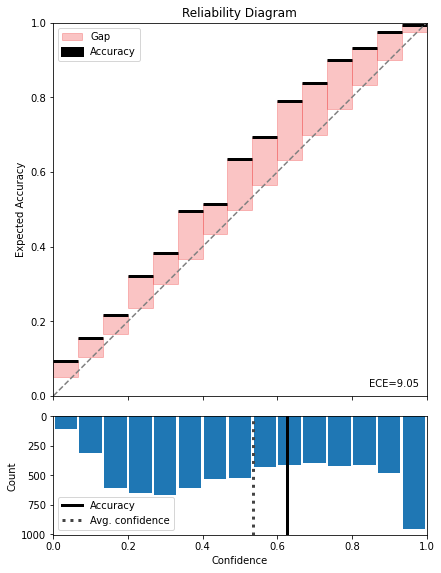

In [101]:
reliability_diagram(
    true_labels=labels,
    pred_labels=np.argmax(probs_swag, axis=-1),
    confidences=probs_swag[
        np.arange(len(probs_swag)),
        np.argmax(probs_swag, axis=-1)
                      ],
     num_bins=15
    )

In [ ]:
# Compute scores for CIFAR100
cifar100_EH_swag, cifar100_HE_swag, cifar100_maxprob_swag = compute_scores_swag(
    swag_model, cifar100_valloader, cifar100_calloader, N_SWAG_SAMPLES, device)

# Compute scores for OOD
cifar10_EH_swag, cifar10_HE_swag, cifar10_maxprob_swag = compute_scores_swag(
    swag_model, cifar10_valloader, cifar100_calloader, N_SWAG_SAMPLES, device)

svhn_EH_swag, svhn_HE_swag, svhn_maxprob_swag = compute_scores_swag(
    swag_model, svhn_valloader, cifar100_calloader, N_SWAG_SAMPLES, device)

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

roc_auc_cifar10_maxprob_swag = plot_histogram_eq_width(axs[0], data1=cifar100_maxprob_swag, data2=cifar10_maxprob_swag, title="Maxprob (cifar10)")
roc_auc_svhn_maxprob_swag = plot_histogram_eq_width(axs[1], data1=cifar100_maxprob_swag, data2=svhn_maxprob_swag, title="Maxprob (svhn)")

plt.tight_layout()
plt.show()

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

roc_auc_cifar10_EH_swag = plot_histogram_eq_width(axs[0], data1=cifar100_EH_swag, data2=cifar10_EH_swag, title="Expected entropy (cifar10)")
roc_auc_svhn_EH_swag = plot_histogram_eq_width(axs[1], data1=cifar100_EH_swag, data2=svhn_EH_swag, title="Expected entropy (svhn)")

plt.tight_layout()
plt.show()

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

roc_auc_cifar10_HE_swag = plot_histogram_eq_width(axs[0], data1=cifar100_HE_swag, data2=cifar10_HE_swag, title="Entropy expectation (cifar10)")
roc_auc_svhn_HE_swag = plot_histogram_eq_width(axs[1], data1=cifar100_HE_swag, data2=svhn_HE_swag, title="Entropy expectation (svhn)")

plt.tight_layout()
plt.show()

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

roc_auc_cifar10_BALD_swag = plot_histogram_eq_width(axs[0],
                                                      data1=np.array(cifar100_HE_swag) - np.array(cifar100_EH_swag),
                                                      data2=np.array(cifar10_HE_swag) - np.array(cifar10_EH_swag),
                                                      title="BALD (cifar10)")

roc_auc_svhn_BALD_swag = plot_histogram_eq_width(axs[1],
                                                   data1=np.array(cifar100_HE_swag) - np.array(cifar100_EH_swag),
                                                   data2=np.array(svhn_HE_swag) - np.array(svhn_EH_swag),
                                                   title="BALD (svhn)")

plt.tight_layout()
plt.show()

In [ ]:
RESULTS.append({
    "method": "swag",
    "ood": "cifar10",
    "HE": roc_auc_cifar10_HE_swag,
    "EH": roc_auc_cifar10_EH_swag,
    "BALD": roc_auc_cifar10_BALD_swag,
    "maxprob": roc_auc_cifar10_maxprob_swag
})

In [ ]:
RESULTS.append({
    "method": "swag",
    "ood": "svhn",
    "HE": roc_auc_svhn_HE_swag,
    "EH": roc_auc_svhn_EH_swag,
    "BALD": roc_auc_svhn_BALD_swag,
    "maxprob": roc_auc_svhn_maxprob_swag
})

# DDU

Рассмотрим теперь детерминированные модели, которые используют эмбеддинги.


Про эти методы в целом нужно сказать, что они очень сильно зависят от геометрии эмбеддингов.

На лекции мы обсуждали существенную проблему ``feature collapse'', когда отображения разных объектов получаются одинаковыми.

В литературе предложено несколько способов борьбы с этим эффектом. Все они сводятся к тому, чтобы модель удовлетворяла условию би-Липшица:

$$
K_1\|x_1 - x_0\| \leq \|f_\theta(x_1) - f_\theta(x_0)\| \leq K_2\|x_1 - x_0\|.
$$

Этого можно добиться следующими способами:

- использовать архитектуру ResNet, что позволит удовлетворить условию Липшица снизу
- использовать одну из техник для удовлетворения условия Липшица сверху. Такими техниками являются 1) weight clipping, 2) gradient penalty и 3) spectral normalization.

В нашем примере мы будем пользоваться спектральной нормализацией.


Так же следует напомнить, что эти методы, в отличии от MC Dropout и SWAG, не требуют вообще никаких изменений ни в архитектуре модели, ни в процессе обучения. На самом деле эти методы можно применять и в ситуациях, когда условие би-Липшица не соблюдается, однако результат будет несколько хуже.

In [60]:
from aux import get_embeddings, compute_log_densities, compute_classwise_mean_cov

In [61]:
# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_conf = PreResNet20Spectral()
model = model_conf.base(*model_conf.args, num_classes=100, **model_conf.kwargs)
model.load_state_dict(torch.load(f'./preresnetspectral20-1.pth', map_location=device))
model = model.to(device)
model.eval()
print("OK!")

OK!


In [62]:
embeddings, labels = get_embeddings(model=model, dataloader=cifar100_trainloader, device=device)

In [63]:
means, covs = compute_classwise_mean_cov(embeddings, labels)

In [64]:
log_densities_cifar100 = compute_log_densities(model, cifar100_valloader, means, covs, device).cpu().numpy()

log_densities_cifar10 = compute_log_densities(model, cifar10_valloader, means, covs, device).cpu().numpy()
log_densities_svhn = compute_log_densities(model, svhn_valloader, means, covs, device).cpu().numpy()

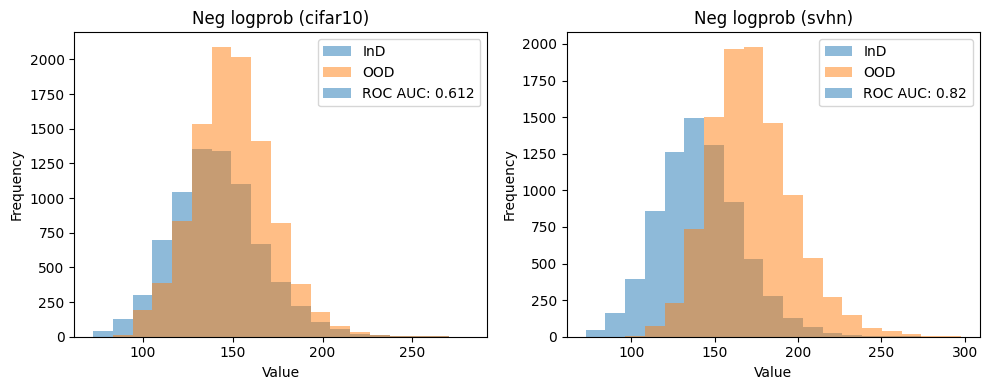

In [65]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

roc_auc_cifar10_ddu = plot_histogram_eq_width(axs[0], data1=-log_densities_cifar100, data2=-log_densities_cifar10, title="Neg logprob (cifar10)")
roc_auc_svhn_ddu = plot_histogram_eq_width(axs[1], data1=-log_densities_cifar100, data2=-log_densities_svhn, title="Neg logprob (svhn)")

plt.tight_layout()
plt.show()

In [66]:
RESULTS.append({
    "method": "ddu",
    "ood": "cifar10",
    "metric": roc_auc_cifar10_ddu
})

In [67]:
RESULTS.append({
    "method": "ddu",
    "ood": "svhn",
    "metric": roc_auc_svhn_ddu
})

# NUQ

В консоле делаем следующее:

https://github.com/stat-ml/NUQ.git

Далее с том виртуальном окружении, в котором запущен ноутбук, такие команды:
cd NUQ
python setup.py develop

После этого всё должно работать.

Если есть проблемы с ray, то нужно ставить версию 1.13.0

In [68]:
from NUQ.nuq import NuqClassifier

In [69]:
nuq_clf = NuqClassifier(log_pN=-10.0)

In [70]:
nuq_clf.fit(X=embeddings.cpu().numpy(), y=labels.cpu().numpy())

  [CLASSIFICATION] bandwidth = 4.240436832074908 (score = 0.7934666666666668)


NuqClassifier(log_pN=-10.0)

In [71]:
embeddings_cifar100, _ = get_embeddings(model=model, dataloader=cifar100_valloader, device=device)

embeddings_cifar10, _ = get_embeddings(model=model, dataloader=cifar10_valloader, device=device)
embeddings_svhn, _ = get_embeddings(model=model, dataloader=svhn_valloader, device=device)

In [72]:
_, nuq_scores_cifar100 = nuq_clf.predict_proba(embeddings_cifar100.cpu().numpy(), return_uncertainty="epistemic")

_, nuq_scores_cifar10 = nuq_clf.predict_proba(embeddings_cifar10.cpu().numpy(), return_uncertainty="epistemic")
_, nuq_scores_svhn = nuq_clf.predict_proba(embeddings_svhn.cpu().numpy(), return_uncertainty="epistemic")

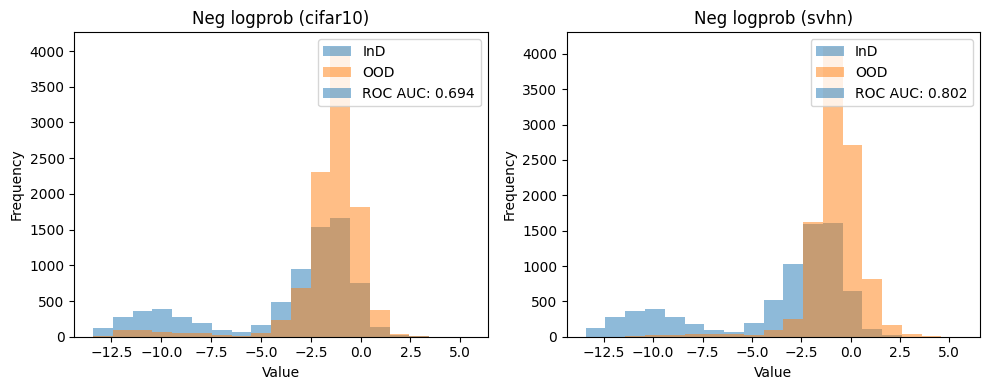

In [73]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

roc_auc_cifar10_nuq = plot_histogram_eq_width(axs[0], data1=nuq_scores_cifar100, data2=nuq_scores_cifar10, title="Neg logprob (cifar10)")
roc_auc_svhn_nuq = plot_histogram_eq_width(axs[1], data1=nuq_scores_cifar100, data2=nuq_scores_svhn, title="Neg logprob (svhn)")

plt.tight_layout()
plt.show()

In [74]:
RESULTS.append({
    "method": "nuq",
    "ood": "cifar10",
    "metric": roc_auc_cifar10_nuq
})

In [75]:
RESULTS.append({
    "method": "nuq",
    "ood": "svhn",
    "metric": roc_auc_svhn_nuq
})

Как видно, эти методы отработали не так хорошо на рассмотренных датасетах.

Однако стоит помнить о том, это методы post-processing, которые можно применить для любой предобученной модели без каких-либо модификаций. Всё что требуется -- использование тренировочного датасета.

# Теперь подведём итоги

In [76]:
df = pd.DataFrame(RESULTS)
df_pivot = df.pivot(index='method', columns='ood')

In [77]:
print(df_pivot)

                 entropy        maxprob             HE             EH         \
ood              cifar10   svhn cifar10   svhn cifar10   svhn cifar10   svhn   
method                                                                         
ddu                  NaN    NaN     NaN    NaN     NaN    NaN     NaN    NaN   
ensemble             NaN    NaN   0.766  0.813   0.769  0.835   0.760  0.800   
ensemble cal         NaN    NaN   0.766  0.816   0.760  0.835   0.754  0.809   
mcdropout            NaN    NaN   0.684  0.774   0.696  0.799   0.690  0.770   
nuq                  NaN    NaN     NaN    NaN     NaN    NaN     NaN    NaN   
single model       0.733  0.745   0.722  0.719     NaN    NaN     NaN    NaN   
single model cal   0.733  0.768   0.730  0.739     NaN    NaN     NaN    NaN   

                    BALD         metric         
ood              cifar10   svhn cifar10   svhn  
method                                          
ddu                  NaN    NaN   0.612  0.820  
ens

In [78]:
df

,method,ood,entropy,maxprob,HE,EH,BALD,metric
0,single model,cifar10,0.733,0.722,NaN,NaN,NaN,NaN
1,single model,svhn,0.745,0.719,NaN,NaN,NaN,NaN
2,single model cal,cifar10,0.733,0.730,NaN,NaN,NaN,NaN
3,single model cal,svhn,0.768,0.739,NaN,NaN,NaN,NaN
4,ensemble,cifar10,NaN,0.766,0.769,0.760,0.777,NaN
5,ensemble,svhn,NaN,0.813,0.835,0.800,0.892,NaN
6,ensemble cal,cifar10,NaN,0.766,0.760,0.754,0.980,NaN
7,ensemble cal,svhn,NaN,0.816,0.835,0.809,0.909,NaN
8,mcdropout,cifar10,NaN,0.684,0.696,0.690,0.748,NaN
9,mcdropout,svhn,NaN,0.774,0.799,0.770,0.934,NaN


In [79]:
df['max_value'] = df[['entropy', 'maxprob', 'HE', 'EH', 'BALD', 'metric']].max(axis=1)

In [81]:
final_df = df[['method', 'ood', 'max_value']]

In [87]:
final_df[final_df.ood == 'svhn'].sort_values(by='max_value', ascending=False)

,method,ood,max_value
9,mcdropout,svhn,0.934
7,ensemble cal,svhn,0.909
5,ensemble,svhn,0.892
11,ddu,svhn,0.820
13,nuq,svhn,0.802
3,single model cal,svhn,0.768
1,single model,svhn,0.745


In [85]:
final_df[final_df.ood == 'cifar10'].sort_values(by='max_value', ascending=False)

,method,ood,max_value
6,ensemble cal,cifar10,0.980
4,ensemble,cifar10,0.777
8,mcdropout,cifar10,0.748
0,single model,cifar10,0.733
2,single model cal,cifar10,0.733
12,nuq,cifar10,0.694
10,ddu,cifar10,0.612


Как видно, ансамбли стабильно показывают сильнейший результат. Это не удивительно, однако следуюет помнить, что обучение ансамблей, ровно как и предсказание, очень дорого с вычислительной точки зрения. По этой причине люди придумали много других, легковесных подходов, которые позволяют получать оценки неопределённости с меньшими вычислительными затратами.

Методы типа SWAG и MC Dropout показывают неплохие результаты, однако требуют изменения в процессе тренировки, либо же дорогие с точки зрения вывода (как в случае SWAG при использовании batch normalization).

Методы типа DDU и NUQ очень просты, быстры и легки в использовании, однако сильно зависят от геометрии признаков (в случае cifar100 vs cifar10 геометрия не очень хорошая), однако могут быть хорошой отправной точкой в рассматриваемой задаче.